# Load in models:

In [1]:
import os
from transformers import CLIPProcessor, CLIPModel
import torch
from segment_anything import SamAutomaticMaskGenerator, SamPredictor, sam_model_registry

import PIL
from PIL import Image
import requests

%load_ext autoreload
%autoreload 2

In [2]:
# Intialize CLIP model
clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

2023-06-17 00:51:01.724213: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# # Initialize SAM model
# model_type = "vit_b"
# sam_checkpoint = os.path.expanduser("/home/ibm-work/segment-anything/models/sam_vit_b_01ec64.pth")
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)

# sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
# sam.to(device=device)
# sam_predictor = SamPredictor(sam)

In [4]:
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
clipseg_processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
clipseg = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

# Load in some images

In [5]:
# url_dict = {}
# with open("urls.txt") as f:
#     url_classes = f.readline()
#     pieces = url_classes.split("|")
#     url = str(pieces[0])
#     classes = [el.strip() for el in pieces[1].split(",")]
#     url_dict[url] = classes

In [6]:
import utils

In [8]:
url = "https://phlearn.com/wp-content/uploads/2018/11/image5-1.jpg"
vocab_custom = ["pole", "dog", "window", "person", "telephone booth", "road", "sign", "cat", "car", "lamp", "tree"]
vocab = utils.deserialize("/home/ibm-work/data/coco_objects/coco_labs.obj") + vocab_custom
image = Image.open(requests.get(url, stream=True).raw)

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip.to(device)
clipseg.to(device)

clip.eval()
clipseg.eval()

CLIPSegForImageSegmentation(
  (clip): CLIPSegModel(
    (text_model): CLIPSegTextTransformer(
      (embeddings): CLIPSegTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (encoder): CLIPSegEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPSegEncoderLayer(
            (self_attn): CLIPSegAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPSegMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=20

In [14]:
len(vocab)

102

In [20]:
from clip_sam_helper import clip_inference, clip_inference_chunks
probs_whole = clip_inference(clip, clip_processor, image, vocab)
probs_chunk = clip_inference_chunks(clip, clip_processor, image, vocab)

> /home/ibm-work/clip_sam_helper.py(43)clip_inference()
     41     if device == "cuda":
     42         pdb.set_trace()
---> 43         inputs = inputs.cuda()
     44 
     45     outputs = model(**inputs)

{'input_ids': tensor([[49406,  8658,  2175, 49407, 49407],
        [49406,  1116, 49407, 49407, 49407],
        [49406,  1769,  8031,   773, 49407],
        [49406,  2972, 49407, 49407, 49407],
        [49406, 11071, 49407, 49407, 49407],
        [49406,  2069,  1929, 49407, 49407],
        [49406,  4298, 49407, 49407, 49407],
        [49406, 13700, 49407, 49407, 49407],
        [49406,  2225, 39877, 49407, 49407],
        [49406,  1929, 49407, 49407, 49407],
        [49406,  4287, 49407, 49407, 49407],
        [49406,  2012,  2292, 49407, 49407],
        [49406, 11652, 49407, 49407, 49407],
        [49406, 33403, 49407, 49407, 49407],
        [49406,  4269, 49407, 49407, 49407],
        [49406,  3801, 49407, 49407, 49407],
        [49406, 27792, 49407, 49407, 49407],
        [4940

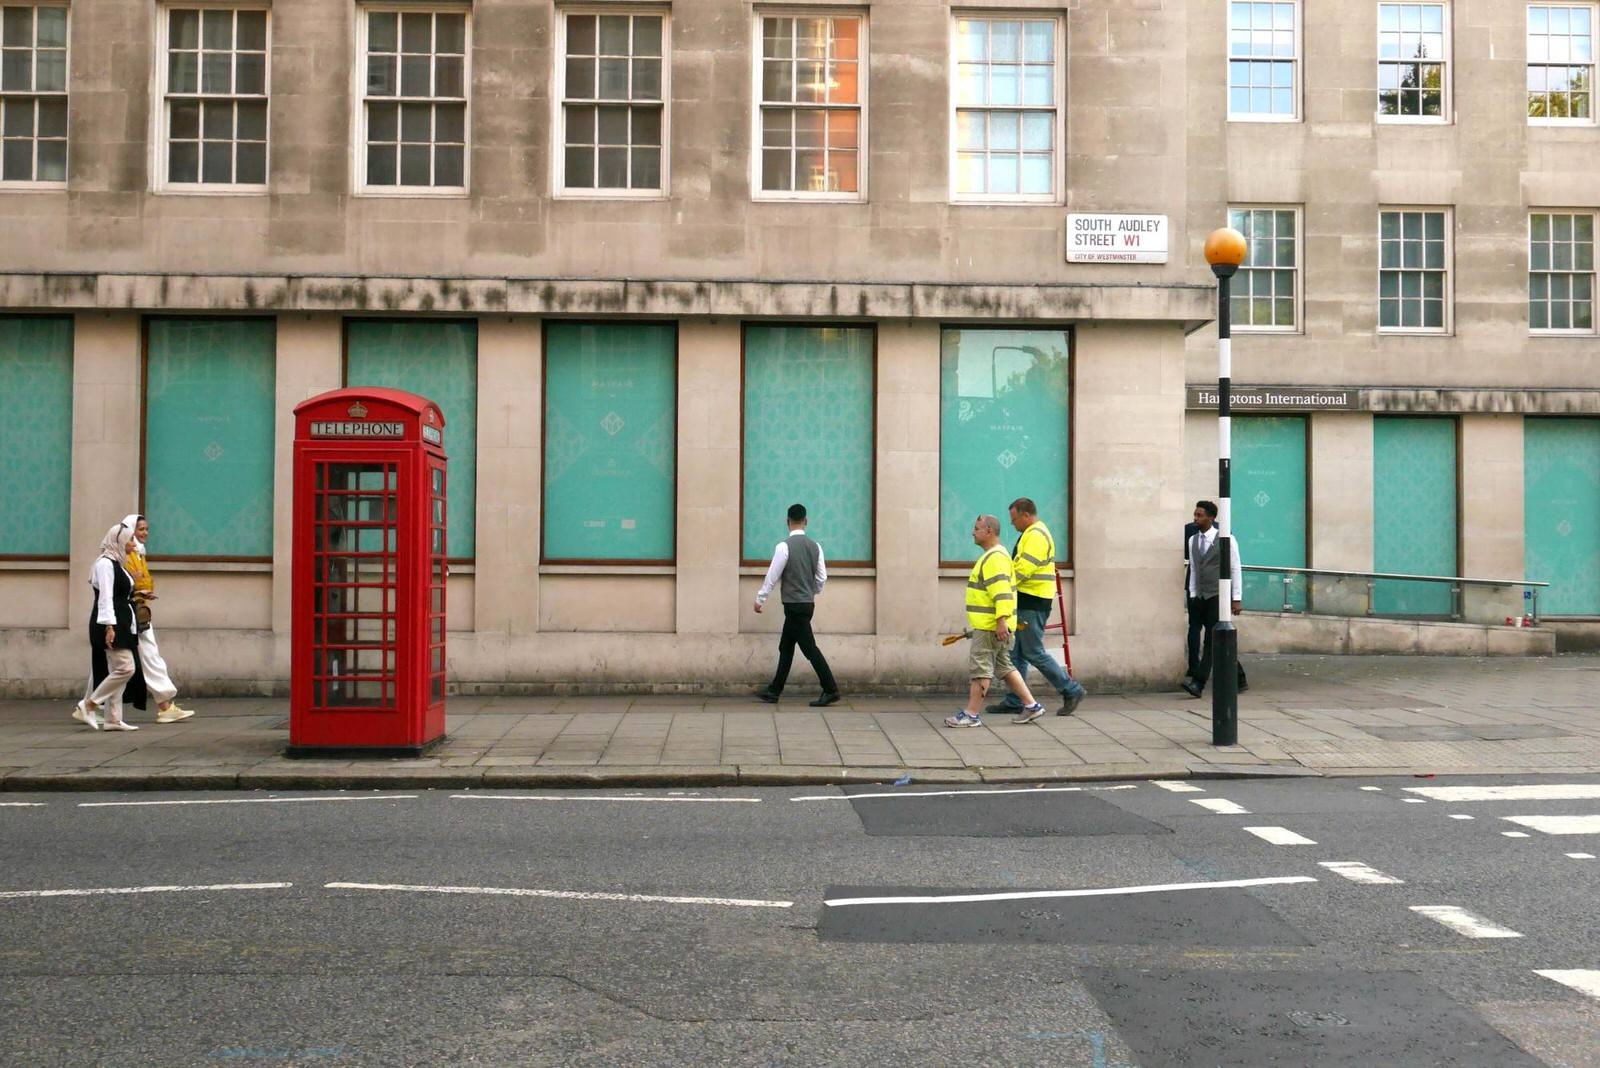

Vocab too large to display all labels... displaying top 10
telephone booth -- 0.9980008006095886
pole -- 0.0013075636234134436
person -- 0.00024047699116636068
window -- 0.00022171913587953895
road -- 0.00011861003440571949
lamp -- 4.0557202737545595e-05
car -- 3.9105758332880214e-05
dog -- 1.441518179490231e-05
sign -- 6.776185728085693e-06
tree -- 6.132221187726827e-06


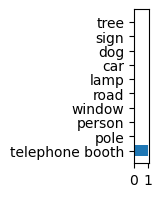

In [15]:
from clip_sam_helper import display_bars, display_image
display_image(image)
display_bars(probs_whole, vocab)

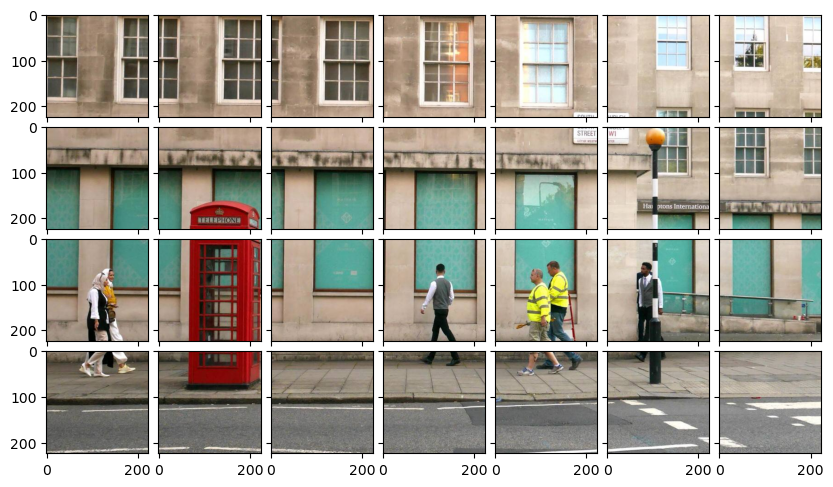

Vocab too large to display all labels... displaying top 10


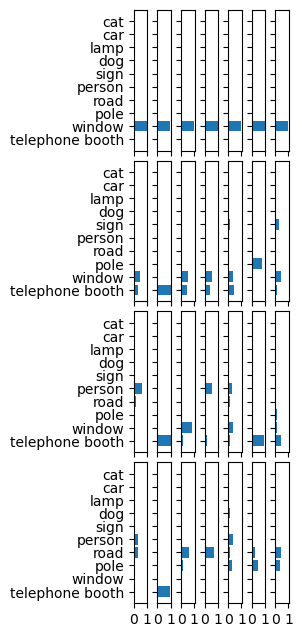

In [31]:
dims = display_image(image, mode="chunks")
display_bars(probs_chunk, vocab, mode="chunks", dims=dims)

# Extract highly probable entities

In [32]:
from clip_sam_helper import extract_entities
entities_dict = extract_entities(probs_whole, probs_chunk, vocab)
entities_dict

{'pole': 0.7520573735237122,
 'dog': 0.15708640217781067,
 'window': 0.9946868419647217,
 'person': 0.6208404898643494,
 'telephone booth': 0.9999244213104248,
 'road': 0.6618263721466064,
 'sign': 0.2872995138168335,
 'cat': 0.04576401039958,
 'car': 0.07727367430925369,
 'lamp': 0.10910062491893768,
 'tree': 0.008308332413434982}

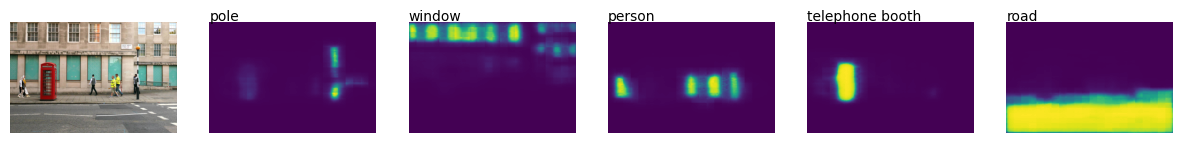

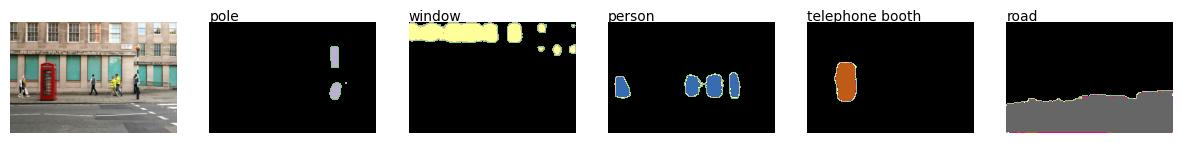

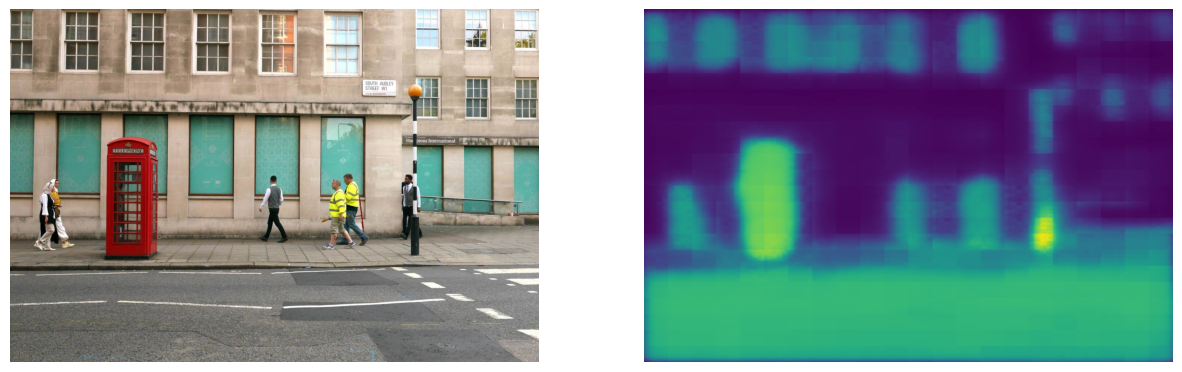

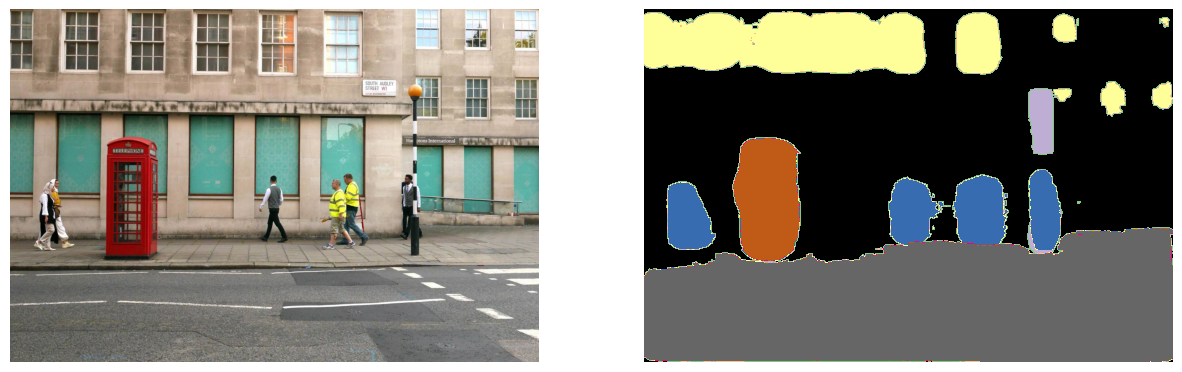

In [52]:
from clip_sam_helper import clipseg_inference
clipseg_inference(clipseg, clipseg_processor, image, entities_dict) 